Version of PyTorch: 0.4.0 , and we used: 0.4.0
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
<class 'torch.Tensor'> torch.Size([316, 28, 500])
<class 'torch.Tensor'> torch.Size([316])
<class 'torch.Tensor'> torch.Size([100, 28, 50])
<class 'torch.Tensor'> torch.Size([100])
Validation shapes 
 torch.Size([16, 1, 28, 50]) torch.Size([16])
Train shapes 
 torch.Size([3000, 1, 28, 50]) torch.Size([3000])
torch.Size([3000, 1, 28, 50])
Test shapes 
 torch.Size([100, 1, 28, 50]) torch.Size([100])

Epoch  0
classification accuracy on training set: 0.5456666946411133
classification accuracy on validation set: 0.8125
classification accuracy on test set: 53.0%

Epoch  1
classification accuracy on training set: 0.5916666388511658
classification accuracy on validation set: 0.6875
classification accuracy on test set: 53.0%

Epoch  2
classification accuracy on training set: 0.6060000061988831
classification accuracy on validation set: 0.5625
classification acc


Epoch  47
classification accuracy on training set: 0.9413333535194397
classification accuracy on validation set: 0.875
classification accuracy on test set: 79.0%

Epoch  48
classification accuracy on training set: 0.9396666884422302
classification accuracy on validation set: 0.875
classification accuracy on test set: 77.0%

Epoch  49
classification accuracy on training set: 0.9483333230018616
classification accuracy on validation set: 0.875
classification accuracy on test set: 77.0%

Epoch  50
classification accuracy on training set: 0.9430000185966492
classification accuracy on validation set: 0.875
classification accuracy on test set: 77.0%

Epoch  51
classification accuracy on training set: 0.9536666870117188
classification accuracy on validation set: 0.875
classification accuracy on test set: 75.0%

Epoch  52
classification accuracy on training set: 0.9520000219345093
classification accuracy on validation set: 0.875
classification accuracy on test set: 77.0%

Epoch  53
classificat


Epoch  98
classification accuracy on training set: 0.9953333139419556
classification accuracy on validation set: 0.8125
classification accuracy on test set: 77.0%

Epoch  99
classification accuracy on training set: 0.9976666569709778
classification accuracy on validation set: 0.8125
classification accuracy on test set: 77.0%

Epoch  100
classification accuracy on training set: 0.9943333268165588
classification accuracy on validation set: 0.8125
classification accuracy on test set: 78.0%

Epoch  101
classification accuracy on training set: 0.9973333477973938
classification accuracy on validation set: 0.8125
classification accuracy on test set: 77.0%

Epoch  102
classification accuracy on training set: 0.996666669845581
classification accuracy on validation set: 0.8125
classification accuracy on test set: 76.0%

Epoch  103
classification accuracy on training set: 0.9973333477973938
classification accuracy on validation set: 0.8125
classification accuracy on test set: 78.0%

Epoch  104
c


Epoch  149
classification accuracy on training set: 0.9993333220481873
classification accuracy on validation set: 0.8125
classification accuracy on test set: 77.0%
time for training :  337.8433070000001  seconds


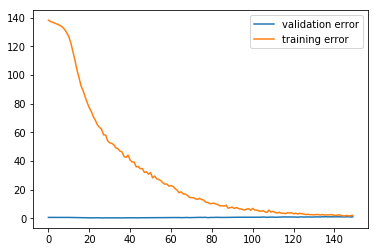

classification accuracy on test set: 77.0%
classification accuracy on test set: 77.0%


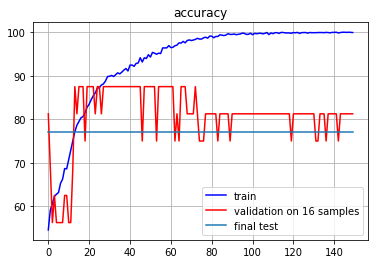

In [20]:
import dlc_bci as bci
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.autograd import Variable
from torch import nn, optim
from torch.nn import functional as F

import random
import time

# fix seeds
torch.manual_seed(0)
random.seed(0)
np.random.seed(0)

# from this same folder
import baseline
from nets import MyNet
from nets import MyNet2
from nets import MyNet3
import helpers
from helpers import BCELoss
from helpers import N_true

print('Version of PyTorch:', torch.__version__,', and we used: 0.4.0')

%load_ext autoreload

%autoreload 2

## Import data

big_data = True 
train_input, train_target = bci.load(root ="./data_bci",download=False, one_khz=big_data)

test_input, test_target = bci.load(root ="./data_bci", train = False, download=False, one_khz=False)

print(str(type(train_input)), train_input.shape)
print(str(type(train_target)), train_target.size())
print(str(type(test_input)), test_input.size())
print(str(type(test_target)), test_target.size())

# Vizualize the data
#helpers.visualize_data(train_input, train_target, test_input,test_target)

# normalize the data
train_input = (train_input - torch.mean(train_input,0,keepdim=True))/torch.std(train_input,0,True)
test_input = (test_input - torch.mean(test_input,0,keepdim=True))/torch.std(test_input,0,True)

# Make non-neural-network baselines
train_input_baselines = train_input.clone()
train_target_baselines = train_target.clone()
#baseline.lousy_baselines(train_input_baselines, train_target_baselines,test_input, test_target)

## Train


t0=time.clock() # save the current time
# set parameters and initialises modules
net = MyNet3()
#optimizer = optim.Adam(net.parameters(), lr=0.00005)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.4)

batch_size = 15
n_max_epochs = 150
n_val_samples = 16

# transform the dataset such that they can be fed to the network
train_X, train_Y, val_X, val_Y = helpers.prepare_train_with_validation(train_input,\
                                                                       train_target,\
                                                                       n_val_samples,\
                                                                       DA=True)
print(train_X.shape)

test_X, test_Y = helpers.prepare_test(test_input,test_target)

train_losses = []
val_losses = []
val_acc = []
train_acc = []
VERBOSE = True

for epoch in range(n_max_epochs):  # loop over the dataset multiple times
    
    net.train() # sets the net in training mode --> dropout activated
    train_loss = 0.0
    num_correct_per_epoch = 0.0
    train_X, train_Y = helpers.shuffle_data(input_=train_X, target_=train_Y) # shuffles the training between epochs
    for b in range(0, train_X.shape[0], batch_size):   #Train batch by batch
        
        # take care of the last batch (which size could not match with the remaining)
        end = batch_size
        if((b+end)>len(train_X)): end=b+end-len(train_X) 
        
        # make predictions and make an optimization step
        output = net(train_X[b:b+end])
        loss = BCELoss(train_Y[b:b+end],output.squeeze())
        loss.backward()
        optimizer.step()
        net.zero_grad()
        
        # update loss and num of correct prediction per batch
        train_loss += loss.data
        num_correct_per_batch = N_true(output, train_Y[b:b+end])
        num_correct_per_epoch += num_correct_per_batch
    
    # evaluate validation 
    net.eval() # set the net in eval mode --> dropout deactivated
    val_pred = net(val_X)
    test_pred = net(Variable(torch.unsqueeze(test_input,1)))
    
    # append values to lists to keep track of the evolution of loss and accuracy
    train_losses.append(train_loss) #add train loss
    train_acc.append(num_correct_per_epoch/train_X.shape[0]) 
    val_losses.append(BCELoss(val_Y,val_pred).data) #add validation loss
    val_acc.append(N_true(val_pred,val_Y)/val_X.shape[0]) #add validation accuracy
    if VERBOSE == True:
        print("\nEpoch ", epoch)
        print("classification accuracy on training set: {}".format(train_acc[epoch].data.numpy()))
        print("classification accuracy on validation set: {}".format(val_acc[epoch].data.numpy()))
        print("classification accuracy on test set: {}%".format((N_true(net(Variable(torch.unsqueeze(test_input,1))),Variable(test_target)))*100/test_input.shape[0]))


        
t1=time.clock() # save the current time
print("time for training : ", t1-t0, ' seconds')
plt.plot(range(epoch+1),val_losses,range(epoch+1),train_losses)
plt.legend(['validation error', 'training error'])
plt.show()

test_pred = net(Variable(torch.unsqueeze(test_input,1)))
print("classification accuracy on test set: {}%".format((N_true(net(Variable(torch.unsqueeze(test_input,1))),Variable(test_target)))*100/test_input.shape[0]))


test_pred = net(Variable(torch.unsqueeze(test_input,1)))
test_acc = (N_true(net(Variable(torch.unsqueeze(test_input,1))),Variable(test_target)))*100/test_input.shape[0]
print("classification accuracy on test set: {}%".format(test_acc))

plt.plot(np.asarray(train_acc)*100,'b', label='train')
plt.plot(np.asarray(val_acc)*100,'r',label='validation on 16 samples')
plt.plot(range(len(train_acc)),torch.ones(len(train_acc)).numpy()*test_acc.numpy(),label='final test')
plt.title('accuracy')
plt.grid(), plt.legend()
plt.show()

